# geometry
## for manipulating geometries

In [1]:
from gerrytools.geometry import *
import matplotlib.pyplot as plt
import geopandas as gpd

### dual graph
This generates a graph dual to the provided geometric data (`GeoDataFrame`)

In [2]:
%%time
vtd_shp = gpd.read_file("data/NC_vtd20/") # North Carolina VTDs
graph = dualgraph(
    vtd_shp,
    index=None, # could pass `GEOID20` to label the nodes by `GEOID20`, otherwise 0-indexed
    colmap={}, # maps old column names to new ones
    buffer=0, # geometric buffer distance (default to 0)
    edges_to_add=[], # edges to add to the graph
    edges_to_cut=[], # edges to remove from the graph
)

CPU times: user 15.6 s, sys: 28.6 ms, total: 15.6 s
Wall time: 15.6 s


### dissolve
This dissolves the geometric data on the column `by`. We generally use this to dissolve a set of source geometries (e.g. VTDs, blocks, etc.) to district geometries. In this case, we'll dissolve our North Carolina VTDs by county, since we don't have a district assignment column.

In [3]:
%%time
counties = dissolve(
    vtd_shp,
    by="COUNTYFP20",
    reset_index=True, # defaults to making the result integer-indexed, not the `by` column
    keep=["TOTPOP20"], # Additional columns to keep beyond the geometry and `by` columns. Defaults to []
    aggfunc="sum", # pandas groupby function type when aggregating; defaults to "sum"
)

CPU times: user 2.42 s, sys: 0 ns, total: 2.42 s
Wall time: 2.42 s


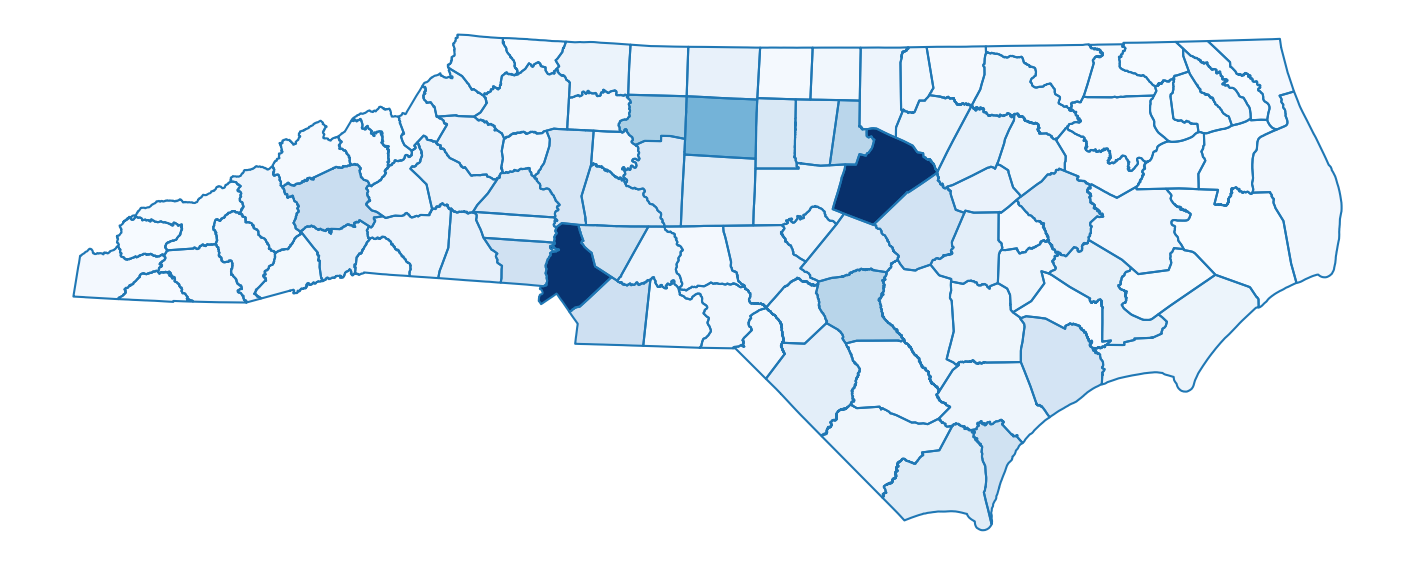

In [4]:
# show that we can now plot the county-level populations
fig, ax = plt.subplots(figsize=(18,8))
ax = counties.plot(
    ax=ax,
    column="TOTPOP20",
    cmap='Blues',
)
ax = counties.boundary.plot(ax=ax)
_ = plt.axis('off')

### unitmap and invert
`unitmap` creates a mapping from source (smaller) units to target (larger) units. `invert` inverts the provided unitmapping, mapping the target (larger) units to lists of source (smaller) units. Often we would want to do this for blocks &rarr; VTDs, but here we'll test this on VTDs &rarr; counties.

In [5]:
%%time
mapping = unitmap((vtd_shp, "GEOID20"), (counties, "COUNTYFP20"))
inverted_mapping = invert(mapping)

100%|██████████| 100/100 [00:01<00:00, 75.17it/s]

CPU times: user 1.34 s, sys: 2.27 ms, total: 1.34 s
Wall time: 1.34 s



/home/peter/Dropbox/MADLAB/Git_Repos/gerrytools-dev/.venv/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [6]:
# VTD 37025008-00 maps to county 025
mapping['37025008-00']

25.0

In [7]:
# county 025 maps to (touches) 40 VTDs, listed here...
inverted_mapping[25.0]

['37025008-00',
 '37025001-10',
 '37025001-07',
 '37025001-08',
 '37025002-08',
 '37025002-09',
 '37025003-00',
 '37025012-04',
 '37025012-03',
 '37025002-06',
 '37025002-07',
 '37025002-02',
 '37025011-01',
 '37025009-00',
 '37025004-01',
 '37025012-11',
 '37025004-08',
 '37025012-12',
 '37025012-08',
 '37025012-09',
 '37025002-03',
 '37025001-02',
 '37025001-04',
 '37025010-00',
 '37025004-03',
 '37025005-00',
 '37025012-05',
 '37025011-02',
 '37025002-05',
 '37025006-00',
 '37025012-10',
 '37025002-01',
 '37025004-09',
 '37025007-00',
 '37025012-06',
 '37025012-13',
 '37025004-12',
 '37025004-11',
 '37025004-13',
 '37025001-11']

### TODO:
`dispersion_updater_closure`, `minimize_parity`, `minimize_dispersion_with_parity`